In [4]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
from sklearn.cluster import KMeans
import json
import numpy as np
import os
from tqdm import tqdm
import time
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity



In [218]:
# Define the transformation to convert grayscale to RGB, upscale the images, and normalize them
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3), #upscaling to rgb 
    transforms.Resize(224), # resize
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [219]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]) 
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)
# Load pre-trained VGG16 model
vgg16 = torchvision.models.vgg16(pretrained=True)
# Modify first layer with 1 channel
# vgg16.features[0] = torch.nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
# Remove the last fully connected layer to get feature extraction layer
vgg16.features = torch.nn.Sequential(*list(vgg16.features.children())[:-1])

C:\Users\paul8\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\paul8\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# # Move model to GPU
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# vgg16 = vgg16.to(device)


# Extracting Features

In [8]:
# # Extract features for each image in the dataset
# features = []
# i = 0
# with torch.no_grad():
#     for image, label in train_dataloader:
#         #print(i)

#         image = image.to(device)
#         features.append(vgg16(image.unsqueeze(0)).cpu().numpy().flatten())
#         #features.append(vgg16(image.unsqueeze(0)).cpu().numpy())
#         #labels.append(labels)
#         #i = i+1


In [9]:
#torch.save(features, 'fashionmnistfeatures.pth')

loaded_tensor = torch.load('fashionmnistfeatures.pth')


In [10]:
len(loaded_tensor)

60000

In [11]:
#splitting into traning features and val dataset

numbers = list(range(60000))
Train_index = random.sample(numbers, 50000)
Val_index = [num for num in numbers if num not in Train_index]
features = []
for i in Train_index:
    features.append(loaded_tensor[i])


In [12]:
len(features)

50000

In [132]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

# Assuming you have already extracted features from your dataset
features_array = np.array(features)

# Perform k-means clustering
n_clusters = 20
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(features_array)

# Get the cluster labels
cluster_labels = kmeans.labels_


C:\Users\paul8\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


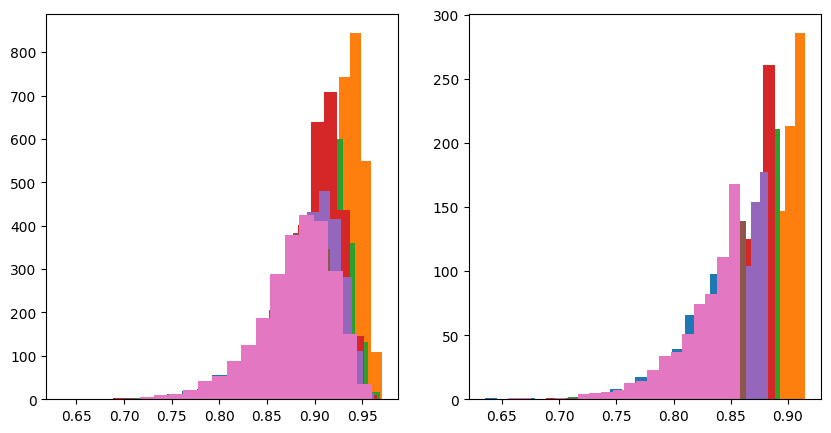

In [187]:

# Group the data by cluster label and calculate cosine similarities
grouped_data = [[] for _ in range(n_clusters)]
for i, feature in enumerate(features_array):
    label = cluster_labels[i]
    grouped_data[label].append((feature, Train_index[i]))


most_similar_data_by_cluster= [[] for _ in range(n_clusters)]
legends = []
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
for i, group in enumerate(grouped_data):
    centroid = kmeans.cluster_centers_[i]
    similarities = cosine_similarity([centroid], [feature for feature, label in group])[0]
    #fig[0] = plt.hist(similarities)
    ax1.hist(similarities, bins=20)
    legends.append(f'group{i}')
    sorted_indices = np.argsort(similarities)[::-1]  # Reverse sort order to get highest similarities first
    #most_similar_indices = sorted_indices[:int(len(group)*0.25)]  # Keep the top 25% of most similar 
    most_similar_indices = sorted_indices[-int(len(group)*0.25):]
    most_similar_items = [(group[j][1]) for j in most_similar_indices]
    most_similar_data_by_cluster[i].extend(most_similar_items)
    pruned_sim = similarities[most_similar_indices]
    #fig[1] = plt.hist(pruned_sim)
    ax2.hist(pruned_sim, bins=20)
    
    if i>5:
        break
plt.show()


In [216]:
img_index = grouped_data[5][sorted_indices[0]][1]
print (img_index)

47546


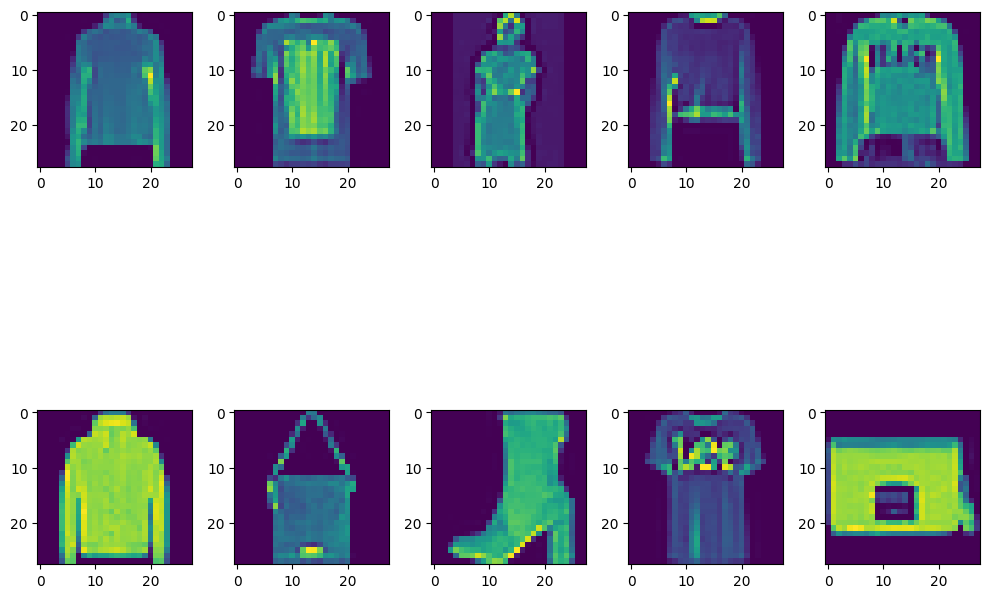

In [230]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]) 
train_dataset_john = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

#img_index= most_similar_data_by_cluster[0][0]
fig, axes = plt.subplots(2, 5, figsize=(10, 10))

for i, ax in enumerate(axes.flat):

    img_index = grouped_data[5][sorted_indices[i]][1]
    ax.imshow(train_dataset_john[img_index][0].permute(1, 2, 0))

plt.tight_layout()
plt.show()


In [188]:
# Create a nested dictionary to store the counts
cluster_counts = {cluster: {label: 0 for label in range(10)} for cluster in range(n_clusters)}

# Count the number of each data label within each group
# for label, cluster in zip(train_dataset.targets, kmeans.labels_):
#     cluster_counts[cluster][label.item()] += 1
for i in range(n_clusters):
    for index in most_similar_data_by_cluster[i]:
        cluster_counts[i][train_dataset[index][1]] += 1
# Print the table header
header = "Cluster | " + " | ".join([f"Label {i}" for i in range(10)])
print(header)
print("-" * len(header))

# Print the table rows
for cluster, label_counts in cluster_counts.items():
    row = f" {cluster:6} |  " + " |  ".join([f"{count:6}" for count in label_counts.values()])
    print(row)

Cluster | Label 0 | Label 1 | Label 2 | Label 3 | Label 4 | Label 5 | Label 6 | Label 7 | Label 8 | Label 9
-----------------------------------------------------------------------------------------------------------
      0 |      57 |       6 |      28 |      79 |      43 |       3 |     192 |       0 |      41 |       9
      1 |      31 |     681 |      24 |     134 |      12 |       1 |      14 |       0 |      17 |       4
      2 |       9 |       2 |       4 |       2 |       2 |     358 |      15 |      88 |      94 |      89
      3 |       0 |       0 |       4 |       0 |       0 |     135 |       0 |     450 |      76 |      56
      4 |     100 |      10 |       9 |     345 |      94 |       0 |      87 |       0 |      26 |       4
      5 |      95 |      21 |      69 |      46 |      45 |      16 |      69 |       2 |     221 |       5
      6 |      48 |     135 |       8 |     340 |      20 |       5 |      52 |       0 |      15 |       9
      7 |       0 |       0 

# Testing the Training Time

In [149]:
#for creating custom dataset
from torch.utils.data import Dataset

class DictDataset(Dataset):
    def __init__(self, data_dict, transform=None):
        self.data_dict = data_dict
        self.transform = transform
        self.keys = list(data_dict.keys())
        self.keys.sort()

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, index):
        # Get the image data and label for the current item
        key = self.keys[index]
        img = self.data_dict[key]['images']
        label = self.data_dict[key]['labels']

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [150]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28) # Flatten the input image
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model and optimizer
model = MLP()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the batch size and number of epochs
batch_size = 128
num_epochs = 30


# Custom Dataset

In [151]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,)),]) 
train_dataset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)

data_dict_50 = {}
index = 0
for i in range(n_clusters):
    for j in most_similar_data_by_cluster[i]:
        data_dict_50[j] = {'images': train_dataset[j][0], 'labels': train_dataset[j][1]}
        index = index+1


custom_dataset = DictDataset(data_dict_50)

# Create the dataloader for the train dataset
train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=128, shuffle=True)


In [155]:
acc_dedup = []
for i in range(20):
    # Initialize the model and optimizer
    model1 = MLP()
    optimizer = optim.Adam(model1.parameters(), lr=0.001)


    # training
    total_iterations = len(train_loader) * num_epochs
    with tqdm(total=total_iterations, desc='Training') as pbar:
        for epoch in range(num_epochs):
            running_loss = 0.0
            for i, (images, labels) in enumerate(train_loader):
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model1(images)
                #print(outputs.shape)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Update the progress bar
                pbar.update(1)

                # Print statistics
                running_loss += loss.item()
                if (i == len(train_loader)-1):
                    #print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
                    running_loss = 0.0

    correct = 0
    total = 0
    #test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
    #test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    #test_loader
    with torch.no_grad():
        for images, labels in test_loader:
            # Forward pass
            outputs = model1(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test accuracy for lower 25% of cosine sim dataset is: {100 * correct/total:.2f}%")
    acc_dedup.append(100 * correct/total)

Training: 100%|██████████| 2940/2940 [00:15<00:00, 193.01it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.04%


Training: 100%|██████████| 2940/2940 [00:18<00:00, 158.30it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.74%


Training: 100%|██████████| 2940/2940 [00:17<00:00, 164.29it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.28%


Training: 100%|██████████| 2940/2940 [00:18<00:00, 161.72it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.39%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 216.73it/s]


Test accuracy for lower 25% of cosine sim dataset is: 86.06%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 219.62it/s]


Test accuracy for lower 25% of cosine sim dataset is: 84.71%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 215.97it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.26%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 211.44it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.52%


Training: 100%|██████████| 2940/2940 [00:19<00:00, 151.77it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.62%


Training: 100%|██████████| 2940/2940 [00:15<00:00, 194.64it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.60%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 214.55it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.77%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 223.52it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.93%


Training: 100%|██████████| 2940/2940 [00:14<00:00, 201.28it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.98%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 212.84it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.68%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 225.68it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.53%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 221.68it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.47%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 224.01it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.62%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 224.22it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.60%


Training: 100%|██████████| 2940/2940 [00:12<00:00, 228.12it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.67%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 224.97it/s]


Test accuracy for lower 25% of cosine sim dataset is: 85.42%


In [156]:
acc_random = []

for i in range(20):
    data_dict_50 = {}
    index = 0
    random_numbers = random.sample(range(50000), int(50000*0.25))
    for k in random_numbers:
        j= Train_index[k]
        data_dict_50[j] = {'images': train_dataset[j][0], 'labels': train_dataset[j][1]}
        index = index+1

    custom_dataset = DictDataset(data_dict_50)

    # Initialize the model and optimizer
    model1 = MLP()
    optimizer = optim.Adam(model1.parameters(), lr=0.001)

    # Create the dataloader for the train dataset
    train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

    # training
    total_iterations = len(train_loader) * num_epochs
    with tqdm(total=total_iterations, desc='Training') as pbar:
        for epoch in range(num_epochs):
            running_loss = 0.0
            for i, (images, labels) in enumerate(train_loader):
                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                outputs = model1(images)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Update the progress bar
                pbar.update(1)

                # Print statistics
                running_loss += loss.item()
                if (i == len(train_loader)-1):
                    #print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}")
                    running_loss = 0.0

    correct = 0
    total = 0
    #test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)
    #test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    with torch.no_grad():
        for images, labels in test_loader:
            # Forward pass
            outputs = model1(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test accuracy for random 25% dataset is: {100 * correct/total:.2f}%")
    acc_dedup.append(100 * correct/total)

Training: 100%|██████████| 2940/2940 [00:12<00:00, 227.34it/s]


Test accuracy for random 25% dataset is: 85.40%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 224.60it/s]


Test accuracy for random 25% dataset is: 86.19%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 220.26it/s]


Test accuracy for random 25% dataset is: 85.10%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 212.19it/s]


Test accuracy for random 25% dataset is: 85.15%


Training: 100%|██████████| 2940/2940 [00:12<00:00, 232.32it/s]


Test accuracy for random 25% dataset is: 84.42%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 220.63it/s]


Test accuracy for random 25% dataset is: 85.59%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 225.92it/s]


Test accuracy for random 25% dataset is: 85.74%


Training: 100%|██████████| 2940/2940 [00:12<00:00, 234.86it/s]


Test accuracy for random 25% dataset is: 85.41%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 224.99it/s]


Test accuracy for random 25% dataset is: 85.47%


Training: 100%|██████████| 2940/2940 [00:12<00:00, 226.48it/s]


Test accuracy for random 25% dataset is: 85.12%


Training: 100%|██████████| 2940/2940 [00:12<00:00, 227.05it/s]


Test accuracy for random 25% dataset is: 84.28%


Training: 100%|██████████| 2940/2940 [00:13<00:00, 217.34it/s]


Test accuracy for random 25% dataset is: 86.25%


Training: 100%|██████████| 2940/2940 [00:21<00:00, 135.67it/s]


Test accuracy for random 25% dataset is: 84.24%


Training: 100%|██████████| 2940/2940 [00:17<00:00, 164.79it/s]


Test accuracy for random 25% dataset is: 85.58%


Training: 100%|██████████| 2940/2940 [00:18<00:00, 155.79it/s]


Test accuracy for random 25% dataset is: 85.34%


Training: 100%|██████████| 2940/2940 [00:21<00:00, 133.71it/s]


Test accuracy for random 25% dataset is: 84.62%


Training: 100%|██████████| 2940/2940 [00:18<00:00, 155.26it/s]


Test accuracy for random 25% dataset is: 85.59%


Training: 100%|██████████| 2940/2940 [00:19<00:00, 151.02it/s]


Test accuracy for random 25% dataset is: 85.71%


Training: 100%|██████████| 2940/2940 [00:18<00:00, 155.64it/s]


Test accuracy for random 25% dataset is: 85.45%


Training: 100%|██████████| 2940/2940 [00:22<00:00, 128.59it/s]


Test accuracy for random 25% dataset is: 85.36%


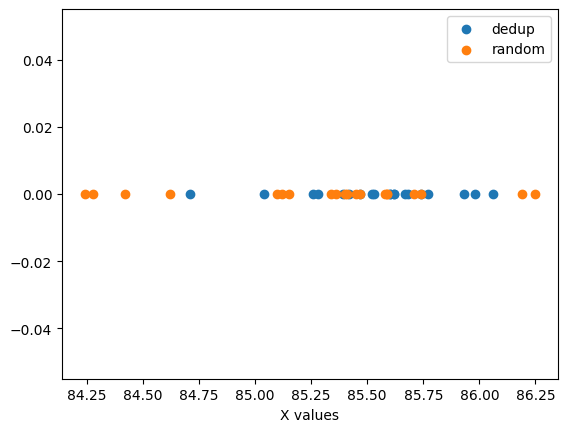

In [172]:
#plt.plot(acc_dedup[:20], 'r', label='acc_dedup')  # 'r' sets the color to red
#plt.plot(acc_dedup[-20:], label='acc_random')

# Create a list of zeros with the same length as the input lists
zeros = [0] * 20

# Create a scatter plot
plt.scatter(acc_dedup[:20], zeros, label = 'dedup')
plt.scatter(acc_dedup[-20:], zeros, label = 'random')

# Set the Y limits to 0
#plt.ylim(ymin=0)

# Add axis labels and a title
plt.xlabel('X values')
plt.legend()

# Show the plot
plt.show()

In [174]:
acc_dedup[-20:]

[85.4,
 86.19,
 85.1,
 85.15,
 84.42,
 85.59,
 85.74,
 85.41,
 85.47,
 85.12,
 84.28,
 86.25,
 84.24,
 85.58,
 85.34,
 84.62,
 85.59,
 85.71,
 85.45,
 85.36]